<a href="https://colab.research.google.com/github/erdemuysalx/ml-algorithms-scratch/blob/main/naivebayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Naive Bayes, Text Classification and Log-Sum-Exp-Trick

Only use the already imported library `numpy`. Make sure that the `liar.txt` dataset is in the same directory as the notebook.

List your team members (name and immatriculation number) in the following cell:


* *names*  ->    Ali Raza, Seemab Hassan, Ramazan Erdem Uysal
* *matr. nr.* ->  3435766, 3568109, 3576094
* *study program* -> Computational Linguistics, Computational Linguistics, INFOTECH
* *B.Sc./M.Sc.* ->  M.Sc., M.Sc., M. Sc.

*of all assignment group participants here.* (double klick here to edit)*

In [1]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/"

Mounted at /content/drive
/content/drive/My Drive


In [2]:
# Load required packages and dataset. Do not modify.
import numpy as np



def load_liar_dataset():
    import string
    
    with open('Machine_Learning/liar.txt', mode='r', encoding='utf-8') as f:
        rows = [l.strip().split('\t')[:2] for l in f]
    
    y, X = zip(*rows)
    X =[x.translate(str.maketrans('', '', string.punctuation)).lower().split() for x in X]
    
    return X, y
    

X, y = load_liar_dataset()

print('Sample:')
print(f'{y[0]}: {X[0]}')
print(f'{y[1]}: {X[1]}')
print(f'{y[2]}: {X[2]}')

Sample:
real: ['thanks', 'to', 'our', 'reforms', 'the', 'average', 'family', 'will', 'have', 'an', 'extra', '322', 'to', 'spend']
real: ['ive', 'got', 'the', 'spending', 'down', 'ive', 'got', 'the', 'debt', 'down', 'a', 'little', 'bit', 'ive', 'got', 'the', 'reserves', 'up']
real: ['winning', 'enough', 'pledged', 'delegates', 'is', 'not', 'impossible']


### Task 2: Fake News Classification with Naive Bayes

Implement a Naive Bayes classifier with Laplace smoothing to detect whether a text message is fake or real (not fake).

A text message is represented by a list of string tokens as shown above.
The classification target is binary and the two possible labels are the strings `'fake'` and `'real'`.

Fill out the methods in `NaiveBayesFakeNewsClassifier` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed.

Hint: Try to map the text messages to word frequency vectors by counting how often each word occurs in a message.

In [19]:
from collections import Counter, defaultdict
from math import log
from pprint import pprint

# Implement your solution here.
class NaiveBayesFakeNewsClassifier(object):
    def __init__(self):
        self.total_docs = None
        self.classes = None
        self.docs_per_class = None
        self.vocabulary = None
        self.vocabulary_size = None
        self.collection_frequency = None
        self.conditional_prob_real = None
        self.conditional_prob_fake = None
    
    def fit(self, X, y):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        y is a list of `n` labels either the string 'Fake' or the string 'real'.
        """

        # creating vocabulary from list 
        flatList = [item for elem in X for item in elem]
        self.vocabulary = set(flatList)
        self.vocabulary_size = len(self.vocabulary) 
       
        # get prior probabilities of each class, and docs per class 
        self.classes, self.docs_per_class = calculate_prior(y)
        
        self.total_docs = len(X) 

        # get the term frequencies 
        term_doc_pointers, vector_lst = term_frequencies(X, self.vocabulary, self.vocabulary_size)
        frequency_vectors = np.array(vector_lst)
        # print("Vector dimenssion : ", frequency_vectors.shape)
        # print("Term frequencies in each document \n", frequency_vectors) 
        # print("Term to document indexes : ", term_doc_pointers)

        # get the term frequencies for each class  
        term_freq_real, term_freq_fake = term_frequencies_category(X, y, term_doc_pointers , self.vocabulary, self.vocabulary_size)

        # get the term probabilities
        self.conditional_prob_fake, self.conditional_prob_real = term_probabilities(self.vocabulary, term_freq_fake, term_freq_real)

    def predict(self, X):
        """
        X is a list of `n` text messages. Each text message is a list of strings with at least length one.
        The method returns a list of `n` strings, i.e. classification labels ('fake' or 'real').
        """
        y_test = []

        # creating vocabulary from list 
        flatList = [item for elem in X for item in elem]
        test_vocab = set(flatList)

        for doc in X:
          # log of prior probabilities
          real_out = log(self.classes['real'])
          fake_out = log(self.classes['fake'])

          for term in test_vocab: 
            # gets the probabilities for new documents from conditional probabilities for real  
            if term in self.conditional_prob_real.keys() and term in doc:
              n = doc.count(term)
              real_out += log(self.conditional_prob_real[term]**n)
            # gets the probabilities for new documents from conditional probabilities for fake  
            if term in self.conditional_prob_fake.keys() and term in doc:
              n = doc.count(term)
              fake_out += log(self.conditional_prob_fake[term]**n)

          # appends the value which is greater to the final list of outputs (posterier)
          if fake_out > real_out:
            y_test.append('fake')
          else:
            y_test.append('real')

        return y_test 


def calculate_prior(y):
  """
  This method will compute the pirior class probabilities of both classes.
  y is a list of `n` labels either the string 'fake' or the string 'real'.
  """

  class1_counter = 0
  class2_counter = 0
  class_prior_probs = dict()

  for observations in y:
    if observations == 'real':
      class1_counter += 1
    else:
      class2_counter += 1
  
  class_prior_probs["real"] = class1_counter/len(y)
  class_prior_probs["fake"] = class2_counter/len(y)

  print("Prior Probabilities of classes: ", class_prior_probs)
  
  return class_prior_probs, [class1_counter, class2_counter]

def term_frequencies(X, vocabulary, vocabulary_size):
  """
  This method will compute the term frequencies in each doc.
  returns a dict of doc_to_index pointers and a vector of term frequencies vectors 
  """
  term_doc_matrix = dict()
  vocabulary = sorted(vocabulary)

  # list for term-frequency vectors 
  vector_lst = [[]] * vocabulary_size
  print("Vocabulary size : ", vocabulary_size)

  for term_id, term in enumerate(vocabulary):
    doc_ids = []

    for id, doc in enumerate(X):
      
      # checks wheather term is present in the document then appends its count and creates posting list 
      if term in doc:
        vector_lst[term_id].append(doc.count(term))
        doc_ids.append(id)

    term_doc_matrix.update( {term : doc_ids} )
    
  return term_doc_matrix, vector_lst  

def term_frequencies_category(X, y, term_doc_pointers, vocabulary, vocabulary_size):
  """
  This method will compute the term frequencies in each class category.
  returns a dict of term_to_category pointers and vectors of term frequencies 
  """
  term_freq_real = dict()
  term_freq_fake = dict()
  
  vocabulary = sorted(vocabulary)
 
 # looking throught the posting lists  
  for term, term_ind in term_doc_pointers.items():

    sum_freq_real = sum_freq_fake = 0 
    
    for id in term_ind: 
      
      # if term belongs to 'real' category then counts its occurence for this category 
      if y[id] == 'real':  
        sum_freq_real += X[id].count(term)      

      # if term belongs to 'fake' category then counts its occurence for this category
      if y[id] == 'fake':
        sum_freq_fake += X[id].count(term)

    # updates the occurences in the final dictionary for both kind of terms which occured in any of the categories and which weren't  
    if sum_freq_real > 0:
      term_freq_real.update({term : sum_freq_real})
    else: 
      term_freq_real.update({term : 0})

    if sum_freq_fake > 0: 
      term_freq_fake.update({term : sum_freq_fake})
    else: 
      term_freq_fake.update({term : 0})

  # print("Real : ", sum(term_freq_real.values()), term_freq_real)
  # print("Fake : ",sum(term_freq_fake.values()), term_freq_fake) 

  return  term_freq_real, term_freq_fake

def term_probabilities(vocabulary, term_freq_fake, term_freq_real):
  """
  Calculates term probabilities for each category/class
  Formula: (Term Frequency + 1)/ (Sum of term frequencies in a category + total no. of terms in a single category)

  returns two dictionaries containinhg term probabilities for real and fake categories respectively 
  """

  term_prob_real = dict()
  term_prob_fake = dict()    

  # computing final likelihoods 
  for fake in term_freq_fake:
    term_prob_fake.update({fake: (term_freq_fake[fake] + 1) / (sum(term_freq_fake.values()) + len(term_freq_fake) )})
  
  for real in term_freq_real:
    term_prob_real.update({real: (term_freq_real[real] + 1) / (sum(term_freq_real.values()) + len(term_freq_real) )})

  # print(term_prob_real)
  # print(term_prob_fake)
  
  
  return term_prob_fake, term_prob_real 
  

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Apply train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

obj = NaiveBayesFakeNewsClassifier()
obj.fit(X_train[:100], y_train[:100])
output = obj.predict(X_test[:50])

Prior Probabilities of classes:  {'real': 0.45, 'fake': 0.55}
Vocabulary size :  879


Prior Probabilities of classes:  {'real': 0.4980392156862745, 'fake': 0.5019607843137255}
Vocabulary size :  9595


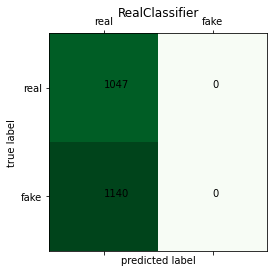

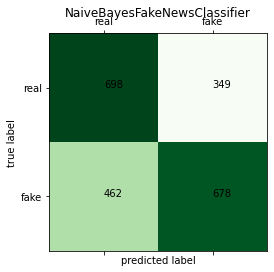

In [5]:
# The following code will evaluate your classifier.
class RealClassifier(object):
    """
    This classifier is a primitive baseline, which just predicts the most common class each time.
    Naive Bayes should definitely beat this.
    """
    def fit(self, X, y): pass
    def predict(self, X): return len(X)*['real']

    
def train_evaluate(classifier, X, y):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split
    
    # Apply train-test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)
    # Inititialize and train classifier.
    classifier.fit(X_train, y_train)
    # Evaluate classifier on test data.
    yhat_test = classifier.predict(X_test)
    cmatrix = confusion_matrix(y_test, yhat_test, labels=['real', 'fake'])
        
    return cmatrix


def plot_confusion_matrix(cmatrix, classifier_name):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1)
    ax.matshow(cmatrix, cmap='Greens')
    for x in (0, 1):
        for y in (0, 1):
            ax.text(x, y, cmatrix[y, x])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
    ax.set_xticklabels(['', 'real', 'fake'])
    ax.set_yticklabels(['', 'real', 'fake'])
    ax.set_title(classifier_name)

    
real_classifier = RealClassifier()
your_classifier = NaiveBayesFakeNewsClassifier()
real_cmatrix = train_evaluate(real_classifier, X, y)
your_cmatrix = train_evaluate(your_classifier, X, y)

plot_confusion_matrix(real_cmatrix, 'RealClassifier')
plot_confusion_matrix(your_cmatrix, 'NaiveBayesFakeNewsClassifier')

### Task 3: Log Sum Exp Trick

Assume you want to apply your Bayesian classifier to a very long text. For the sake of simplicity there is only a single word $x$ and two classes $c=0$ and $c=1$. So given you have a sentence $s$ of length $n$ (only composed out of the word $x$) the probability of a class is

$$ p(c | s) = \frac{p(x | c)^{n} p(c)}{\sum_{c'}p(x | c')^{n} p(c')} $$

So the probability should converge towards $1$ with increasing $n$ for the class with the higher probability of the word $p(x|c)$. Let's implement the equation as found in the textbook and see what happens if we increase $n$.

In [6]:
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

def posterior(n):
    """
    Probability of a class given a sentence of length n.
    """
    word_given_class = np.asarray([0.095, 0.096])
    sentence_likelihood = np.power(word_given_class, int(n))
    prior = np.ones(2) / 2
    posterior = (sentence_likelihood * prior) / (sentence_likelihood.T @ prior)
    return posterior

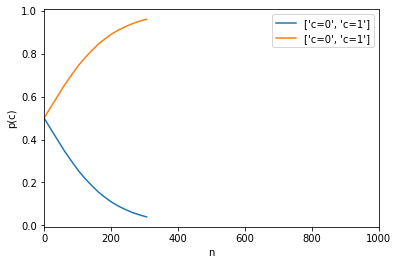

In [7]:
plt.plot(np.linspace(0,1e3,50), [posterior(n) for n in np.linspace(0, 1e3, 50)], label=['c=0', 'c=1'])
plt.xlim(0, 1e3)
plt.xlabel('n')
plt.ylabel('p(c)')
plt.legend()
plt.show()

Oh, that is not what we expected. Do you understand what happend here?

In [8]:
posterior(n=500)

array([nan, nan])

You are observing an numerical underflow, as you multiplied too many small numbers beyond the precision of floating point numbers.

A common approach is to deal with probabilities in logspace (sometimes also called logits) to make the computations more stable.

**Task**: Implement the posterior computation from above in logspace. (compare slide 39 "Implementation Details")

In [9]:
def posterior_logspace(n):
    """
    Computation of the posterior (same as above) in logspace.
    Hint: use np.exp() on the return value to return a valid probability instead of logits
    """

    word_given_class = np.asarray([0.095, 0.096])
    sentence_likelihood = np.power(word_given_class, int(n))
    prior = np.ones(2) / 2
    posterior = (sentence_likelihood * prior) / (sentence_likelihood.T @ prior)
    return np.exp(posterior)
    

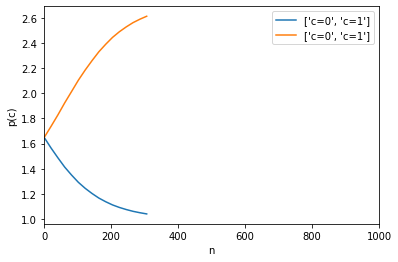

In [10]:
plt.plot(np.linspace(0,1e3,50), [posterior_logspace(n) for n in np.linspace(0, 1e3, 50)], label=['c=0', 'c=1'])
plt.xlim(0, 1e3)
plt.xlabel('n')
plt.ylabel('p(c)')
plt.legend()
plt.show()

This did not really fix the problem, right?

The problem is the expression `np.log(np.sum(np.exp(...)))` in your code, especially the sum of very small probabilities after leaving logspace with `np.exp()`. Can you improve the stability of this operation?

**Task**: Implement the same computation using the so-called log-sum-exp trick (see the hint below). 

Hint: Try to rewrite the expression by subtracting the maximum of all logits from each individual logit. What needs to be added in the end in order to not change the result of the computation?

Btw., it is forbidden to use `np.logaddexp()` in this task, since it is already implementing the trick we are looking for in this task.

In [17]:
def posterior_logsumexp_trick(n):
    """
    Task: Implement the Log-Sum-Exp-Trick
    """
    word_given_class = np.asarray([0.095, 0.096])
    sentence_likelihood = np.power(word_given_class, int(n))
    prior = np.ones(2) / 2
    posterior = (sentence_likelihood * prior) - (sentence_likelihood.T @ prior)
    return np.exp(posterior)

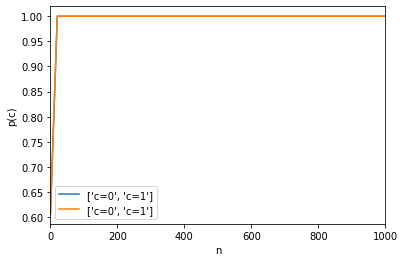

In [18]:
plt.plot(np.linspace(0,1e3,50), [posterior_logsumexp_trick(n) for n in np.linspace(0, 1e3, 50)], label=['c=0', 'c=1'])
plt.xlim(0, 1e3)
plt.xlabel('n')
plt.ylabel('p(c)')
plt.legend()
plt.show()

The resulting computation should now be stable for all $n$ within the range of the plot.